# Logistic Regression & Imbalaced data (강재영)

### -- Heart Disease Prediction --
#### https://www.kaggle.com/naveengowda16/logistic-regression-heart-disease-prediction?select=framingham_heart_disease.csv 데이터 사용

In [6]:
#데이터 셋 호출
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings(action='ignore')

train = pd.read_csv('framingham_heart_disease.csv')
train.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [7]:
#데이터 셋 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


### train
#### · male: 성별
#### · age: 나이
#### · education: 교육수준
#### · currentSmoker: 현재 흡연유무
#### · cigsPerDay: 하루 흡연량
#### · BPMeds: 혈압약 복용 여부
#### · prevalentStroke: 뇌졸중 이력
#### · prevalentHyp: 고혈압 이력
#### · diabetes: 당뇨병 여부
#### · totChol: 총 콜레스테롤 수치
#### · sysBP: 수축기 혈압
#### · diaBP: 이완기 혈압
#### · BMI: 체질량 지수
#### · heartRate: 심박수
#### · glucose: 포도당 지수
#### · TenyearCHD: 10년 내 관상동맥성 심장병 발병 여부

In [8]:
#결측치 개수 확인
train.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [9]:
#pandas_profiling 통해 시각화
import pandas_profiling
report = pandas_profiling.ProfileReport(train)
display(report)

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

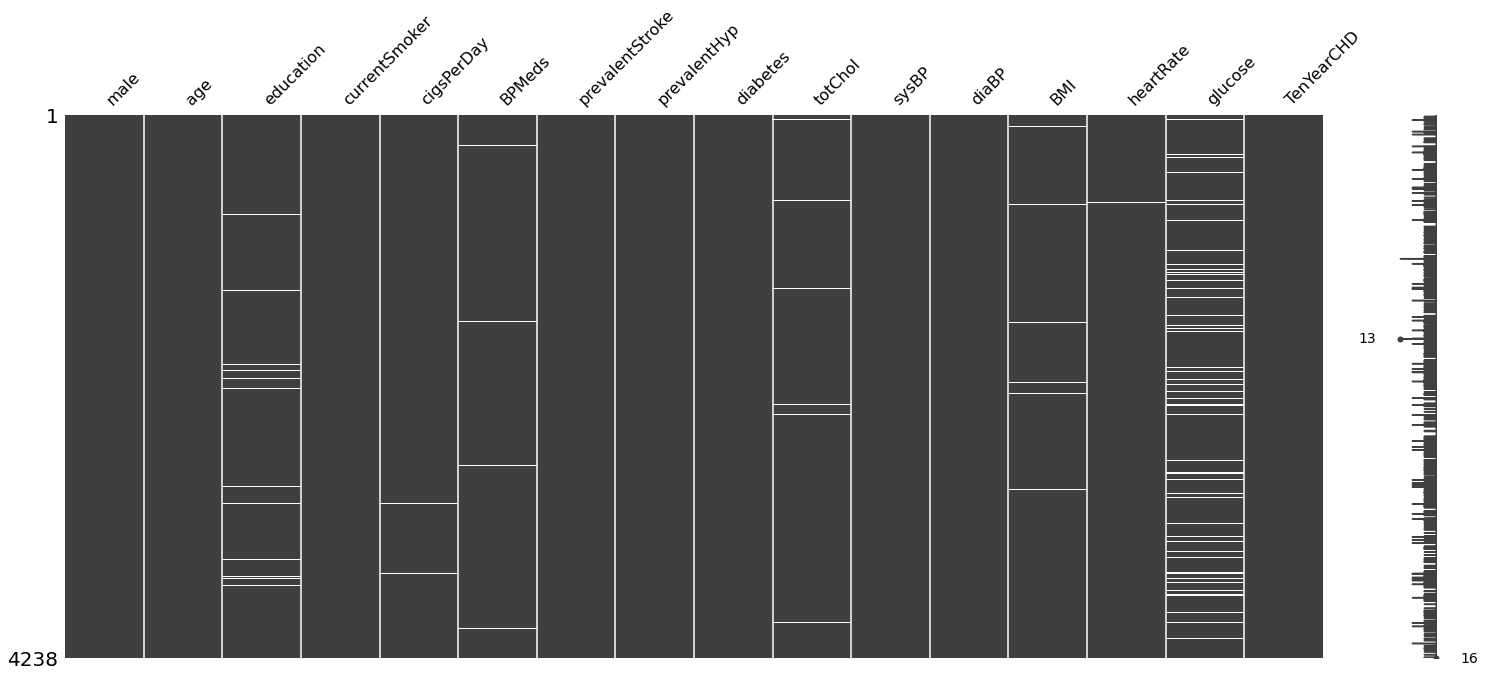

In [10]:
#결측치 시각화
import missingno as msno
msno.matrix(train)

Imported AutoViz_Class version: 0.0.83. Call using:
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 does not show plot but creates them and saves them in AutoViz_Plots directory in your local machine.
Shape of your Data Set loaded: (4238, 16)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  8
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  7
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0


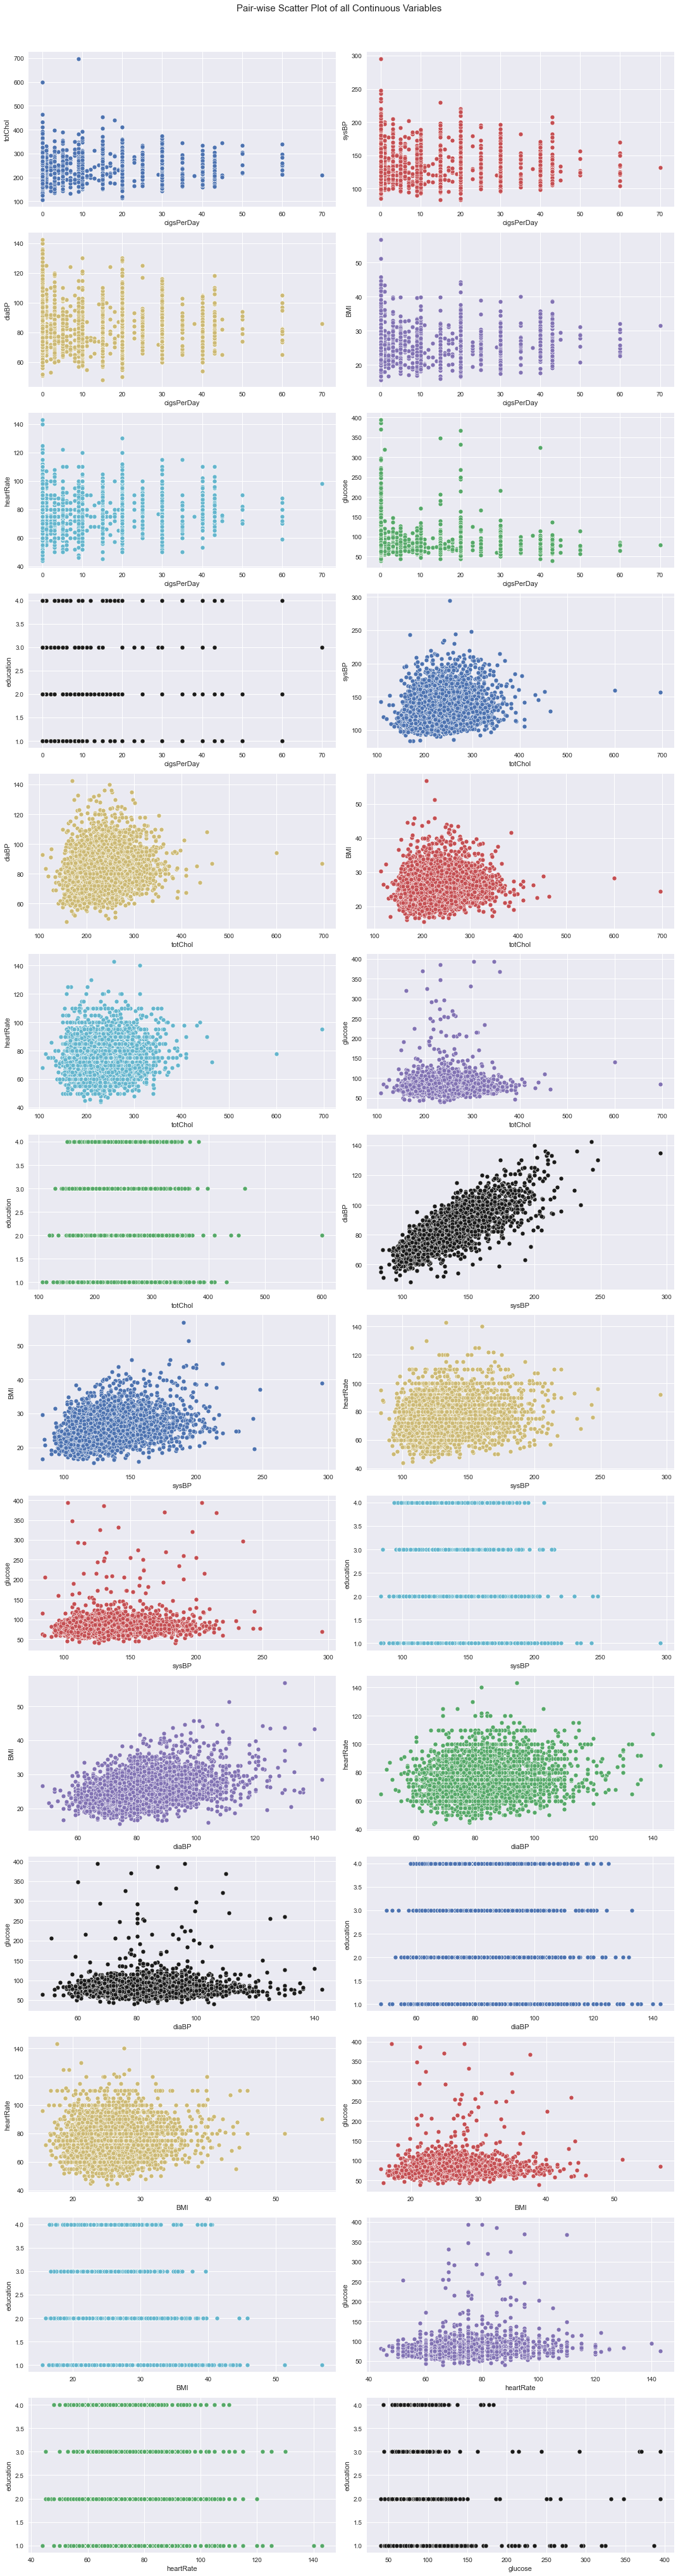

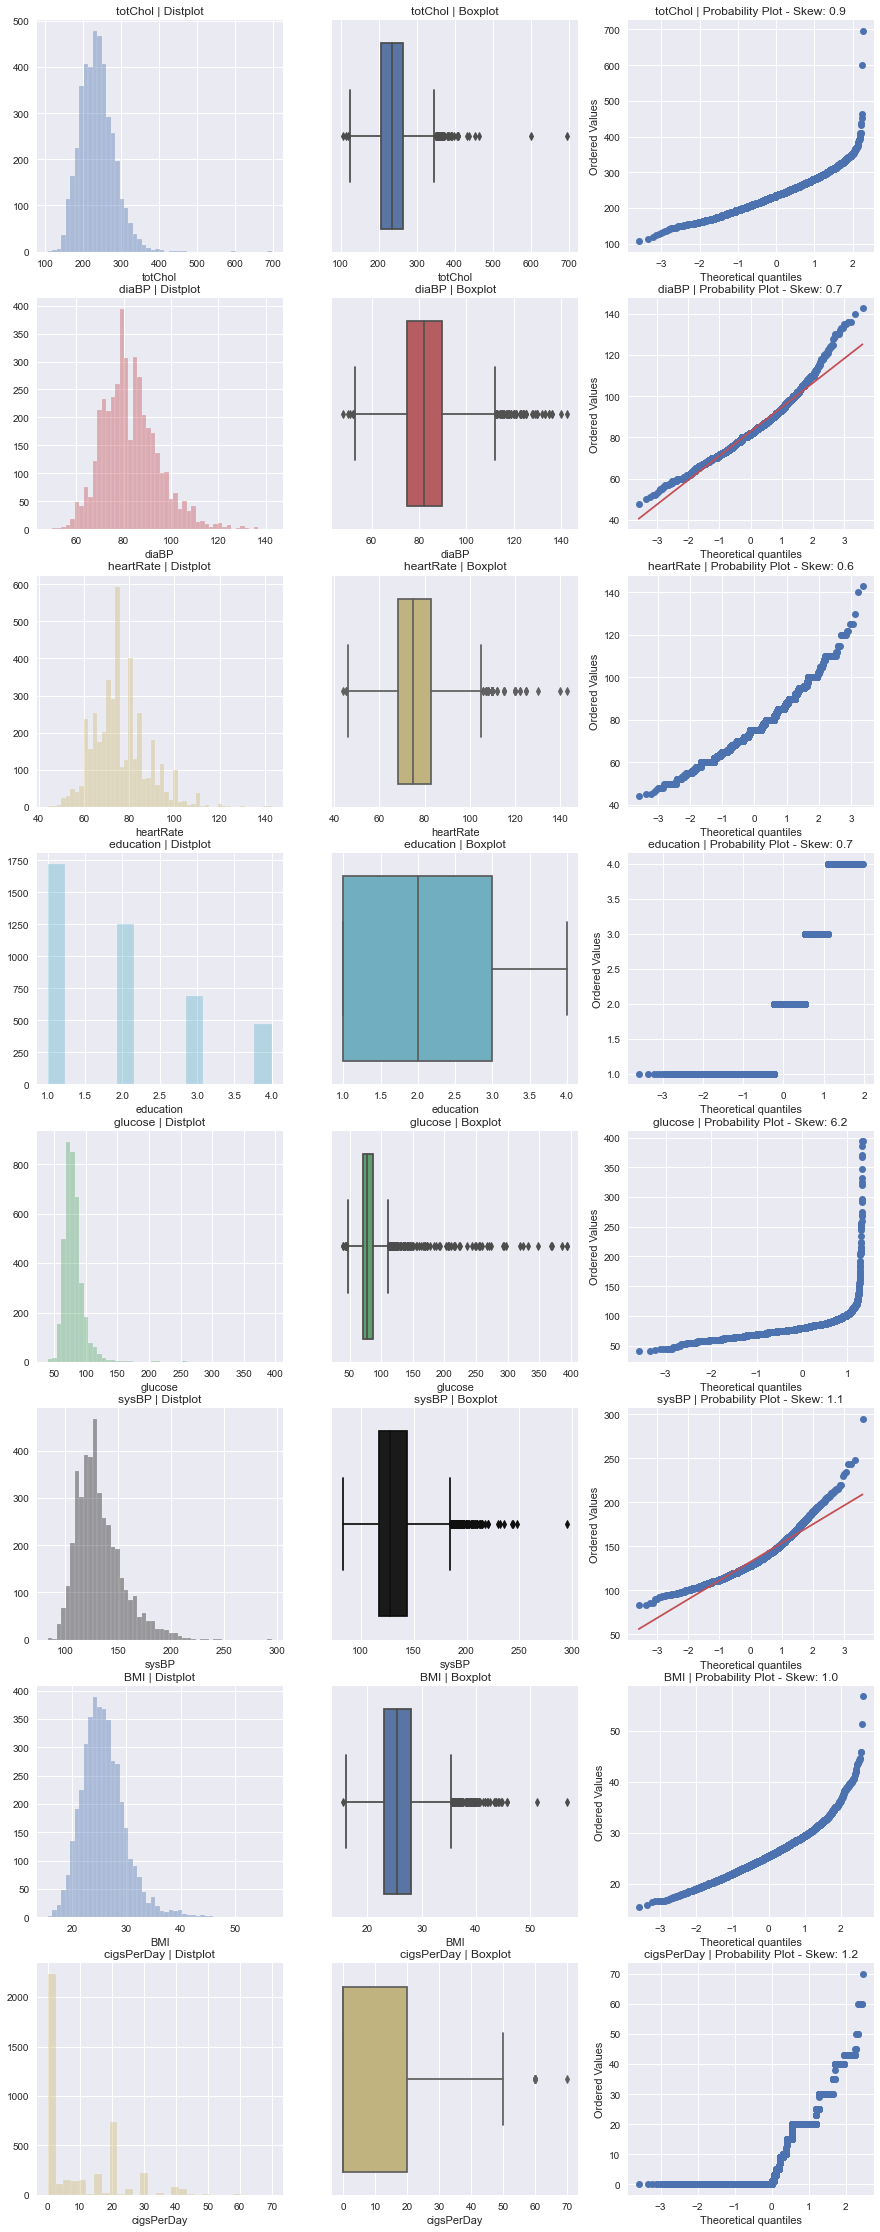

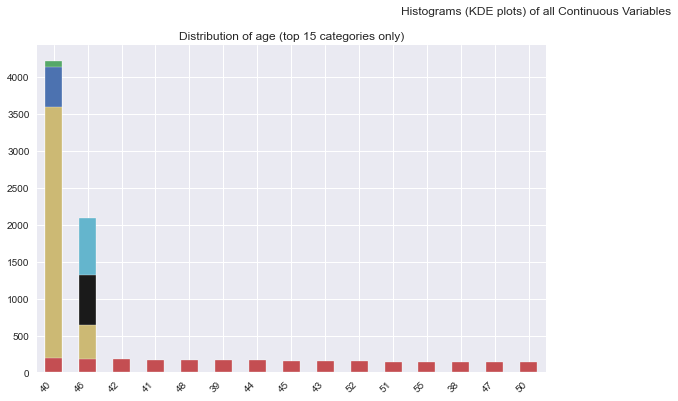

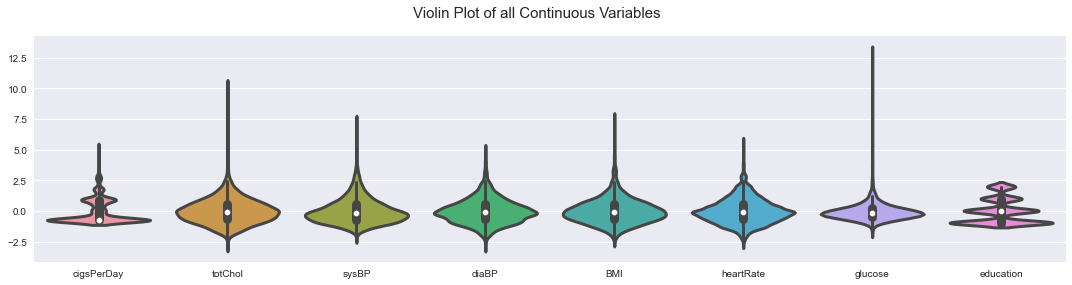

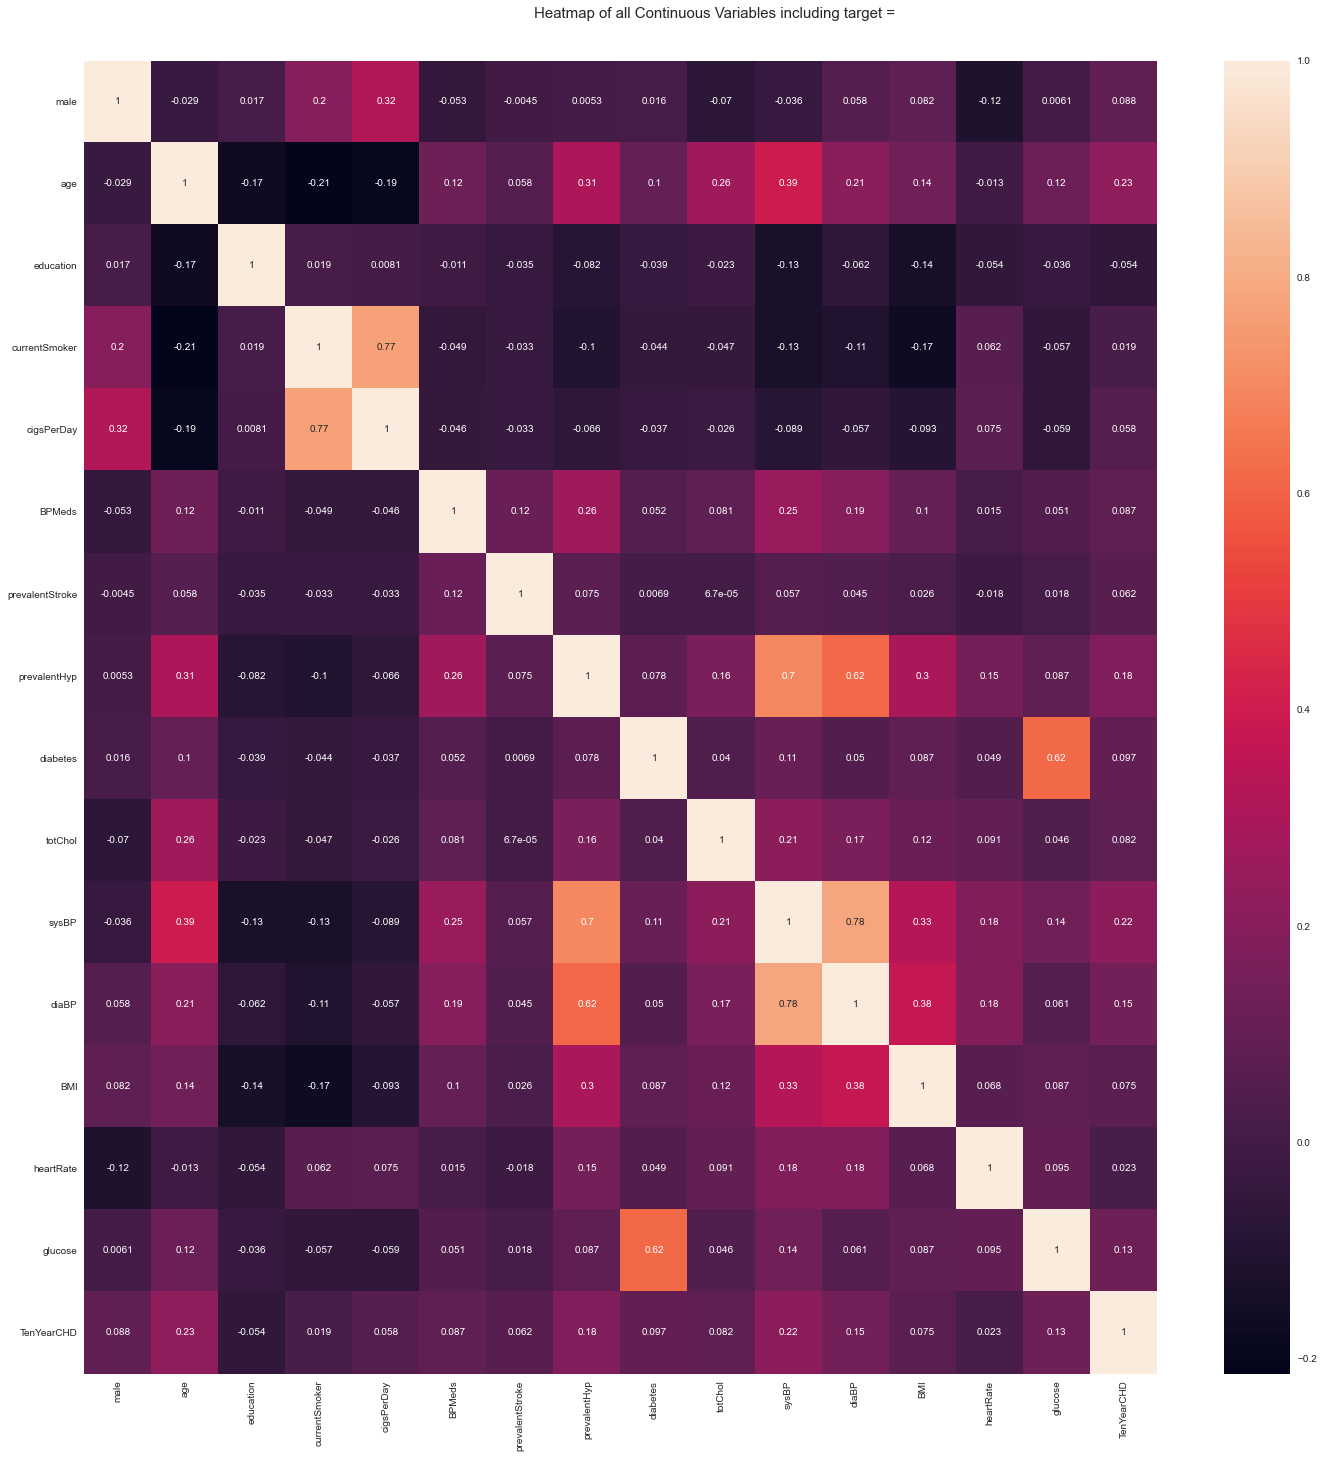

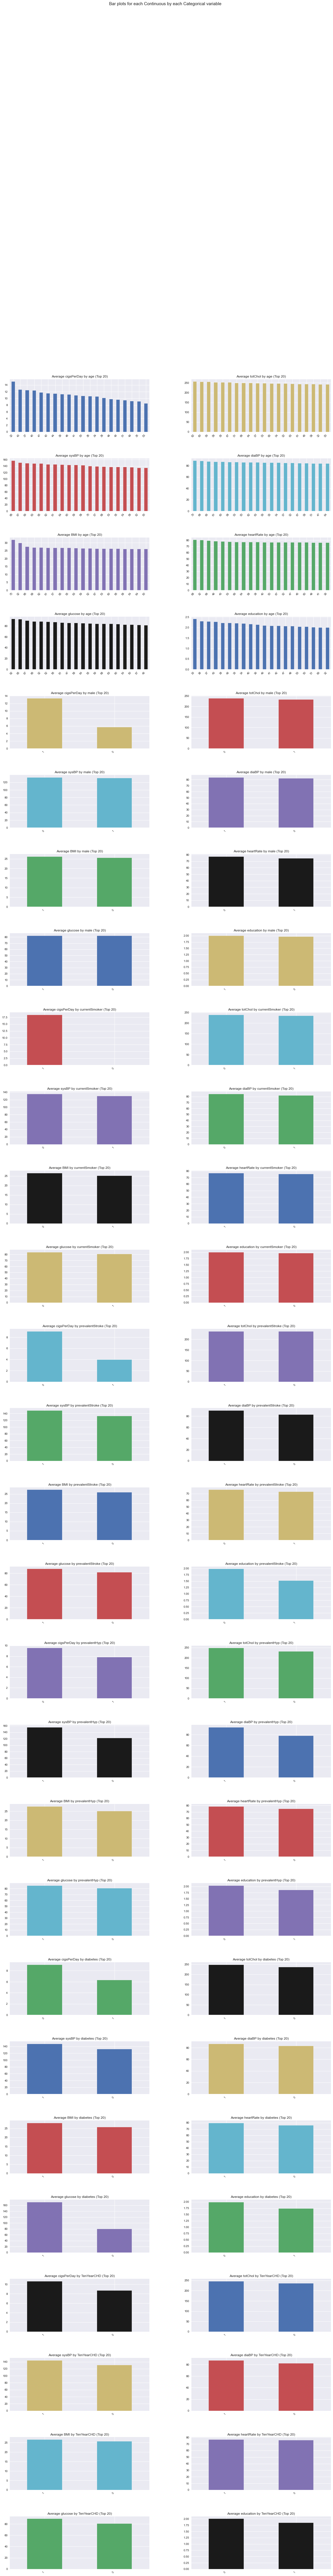

Time to run AutoViz (in seconds) = 17.790

 ###################### VISUALIZATION Completed ########################


In [11]:
#데이터 시각화
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
report2 = AV.AutoViz('framingham_heart_disease.csv')

In [12]:
#education은 심장병에 영향을 미치지 않기 때문에 삭제
train = train.drop('education',axis=1)
#currentSmoker은 하루 흡연량 칼럼이 있기 때문에 대체할 수 있으므로 삭제
train = train.drop('currentSmoker',axis=1)
#cigsPerDay, BPMeds 결측치는 0으로 대체
train['cigsPerDay'] = train['cigsPerDay'].fillna(0)
train['BPMeds'] = train['BPMeds'].fillna(0)
#totChol, BMI, heartRate, glucose 결측치는 평균값으로 대체
train = train.fillna({'totChol': train['totChol'].mean()})
train = train.fillna({'BMI': train['BMI'].mean()})
train = train.fillna({'heartRate': train['heartRate'].mean()})
train = train.fillna({'glucose': train['glucose'].mean()})

In [13]:
#결측치 개수 확인
train.isna().sum()

male               0
age                0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

array([[<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'cigsPerDay'}>,
        <AxesSubplot:title={'center':'BPMeds'}>],
       [<AxesSubplot:title={'center':'prevalentStroke'}>,
        <AxesSubplot:title={'center':'prevalentHyp'}>,
        <AxesSubplot:title={'center':'diabetes'}>,
        <AxesSubplot:title={'center':'totChol'}>],
       [<AxesSubplot:title={'center':'sysBP'}>,
        <AxesSubplot:title={'center':'diaBP'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'heartRate'}>],
       [<AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'TenYearCHD'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

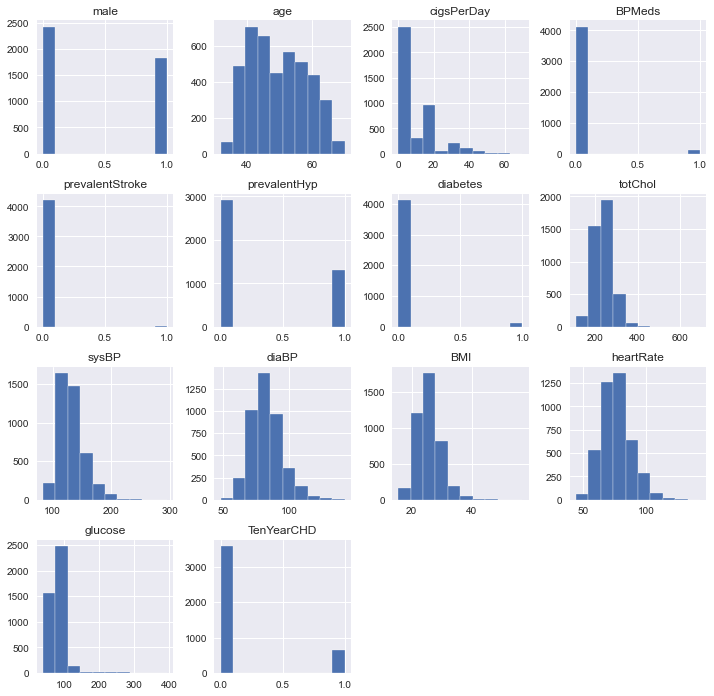

In [14]:
#히스토그램 표현
train.hist(figsize=(12,12))

<AxesSubplot:title={'center':'Target Rate'}, ylabel='TenYearCHD'>

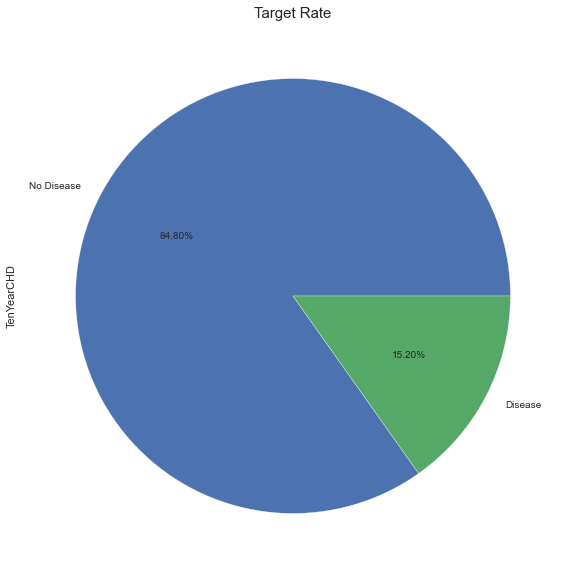

In [15]:
#타겟에 대한 비율을 파이 차트로 표현
plt.figure(figsize=(10,10))
plt.title('Target Rate', fontsize=15)
train['TenYearCHD'].value_counts().plot.pie(autopct='%1.2f%%',
                                            labels=['No Disease', 'Disease'])

### 데이터 불균형 확인됨

In [16]:
train_male = train["male"].value_counts()
train_BPMeds = train["BPMeds"].value_counts()
train_prevalentStroke = train["prevalentStroke"].value_counts()
train_prevalentHyp = train["prevalentHyp"].value_counts()
train_diabetes = train["diabetes"].value_counts()

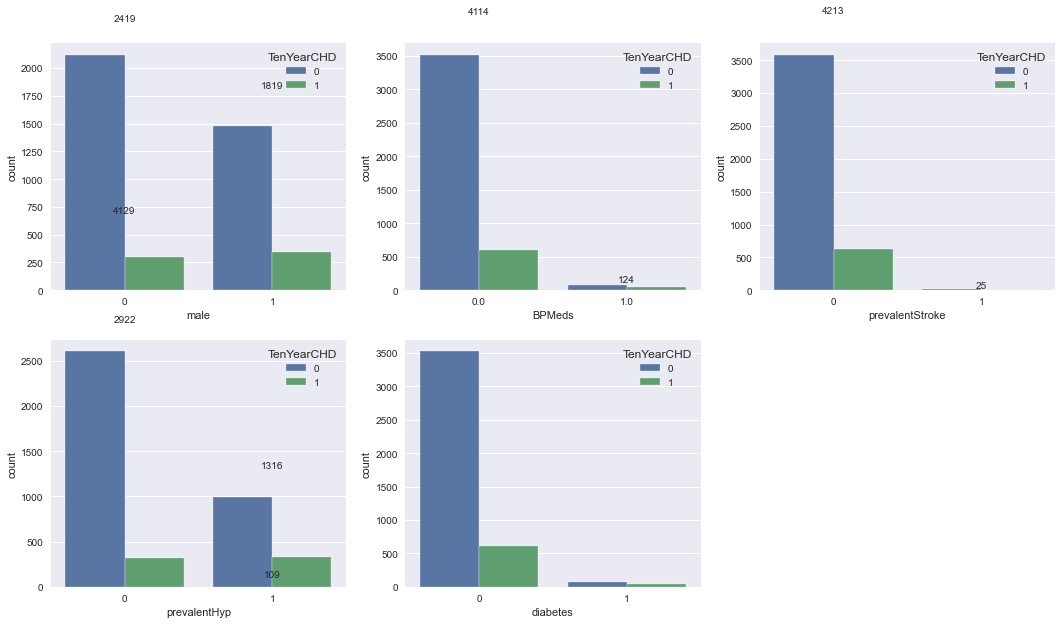

In [17]:
#범주형 column 시각화
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
a = sns.countplot(data=train,x='male',hue='TenYearCHD')
for i in range (train_male.shape[0]):
    a.text(x=i, y=train_male[i], s=train_male[i], horizontalalignment='center')
        
plt.subplot(2,3,2)
b = sns.countplot(data=train,x='BPMeds',hue='TenYearCHD')
for i in range (train_BPMeds.shape[0]):
    b.text(x=i, y=train_BPMeds[i], s=train_BPMeds[i], horizontalalignment='center')

plt.subplot(2,3,3)
c = sns.countplot(data=train,x='prevalentStroke',hue='TenYearCHD')
for i in range (train_prevalentStroke.shape[0]):
    c.text(x=i, y=train_prevalentStroke[i], s=train_prevalentStroke[i], horizontalalignment='center')
    
plt.subplot(2,3,4)
d = sns.countplot(data=train,x='prevalentHyp',hue='TenYearCHD')
for i in range (train_prevalentHyp.shape[0]):
    d.text(x=i, y=train_prevalentHyp[i], s=train_prevalentHyp[i], horizontalalignment='center')

    
plt.subplot(2,3,5)
e = sns.countplot(data=train,x='diabetes',hue='TenYearCHD')
for i in range (train_diabetes.shape[0]):
    d.text(x=i, y=train_diabetes[i], s=train_diabetes[i], horizontalalignment='center')

#값을 주석으로 표현

In [18]:
#x, y에 대해 정의
x=train.drop('TenYearCHD',axis=1)
y=train['TenYearCHD']

In [19]:
#데이터 셋 분리
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,
                                               test_size=0.3,random_state=0)

### - Confusion Maxrix (오차행렬): 예측값과 실제값을 비교하기 위한 표
#### 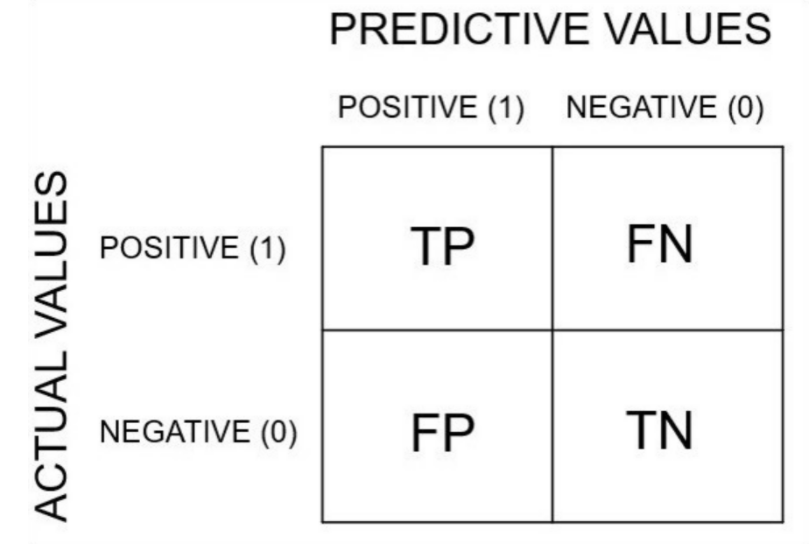

### - Accuracy(정확도)
#### : 올바르게 예측된 데이터의 수를 전체 데이터의 수로 나눈 값
#### Confusion Matrix에서 (TP+TN) / 전체에 해당

### - Precision(정밀도)
#### : 모델이 Positive라고 예측한 것 중 실제값이 Positive인 비율
#### Confusion Matrix에서 TP / (TP+FP)에 해당

### - Recall(재현율)
#### : 실제값이 Positive인 것 중 모델이 Positive라고 예측한 비율
#### Confusion Matrix에서 TP / (TP+FN)에 해당

### - F1 Score
#### : 정밀도와 재현율의 조화 평균
#### (2 Precision Recall) / (Precision+Recall)
#### *데이터가 불균형할 시 사용됨

### - ROC Curve(Receiver-Operating Characteristic curve)
#### : 민감도와 특이도의 관계가 보이는 양상을 2차원 평면상에 그려낸 것
#### 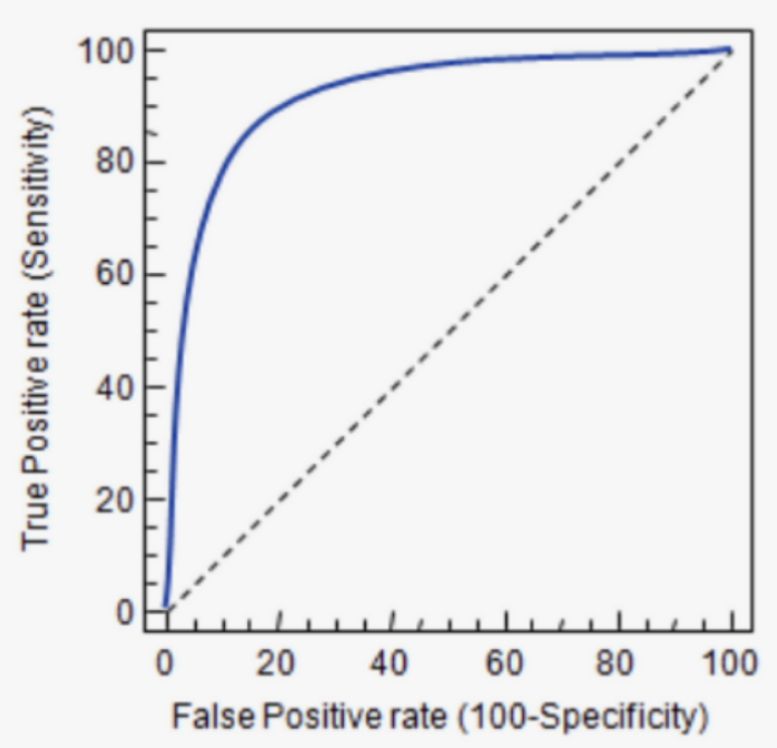
### - AUC(Area Under Curve)
#### : ROC Curve의 면적, AUC의 값이 1일 수록 좋은 모델이라 평가된다.

In [20]:
#로지스틱 회귀 이용하여 학습 및 예측 수행
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_preds = lr_clf.predict(x_test)

#정확도, 정밀도, 재현율, f1_score, roc_auc 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#정확도: 실측값, 예측값 순으로 작성
print('accuracy:{:0.4f}'.format(accuracy_score(y_test, lr_preds)))
print('precision:{:0.4f}'.format(precision_score(y_test, lr_preds)))
print('recall:{:0.4f}'.format(recall_score(y_test, lr_preds)))
print('f1:{:0.4f}'.format(f1_score(y_test, lr_preds)))
print('roc_auc:{:0.4f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy:0.8467
precision:0.6154
recall:0.0404
f1:0.0758
roc_auc:0.5179


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lr_preds)

array([[1069,    5],
       [ 190,    8]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1074
           1       0.62      0.04      0.08       198

    accuracy                           0.85      1272
   macro avg       0.73      0.52      0.50      1272
weighted avg       0.81      0.85      0.79      1272



### - 로지스틱 회귀의 주요 하이퍼 파라미터: C, penalty
#### · C: 규제 강도를 조절하는 alpha 값의 역수
#### (C값이 작을 수록 규제 강도가 큼)
#### · penalty: L1 규제와 L2 규제
#### (L1 규제 --> 0이 됨, L2 규제 --> 0에 가까워짐)

#### - GridSearchCV를 이용하여 최적화

In [23]:
# GridSearchCV: 그리드를 사용한 복수 하이퍼 파라미터 최적화
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1','l2'],'C':[0.01, 0.1, 1, 1, 5, 10], 'max_iter': [10, 30, 50, 100, 300, 500, 1000]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='recall', cv=3)
grid_clf.fit(x, y)

#best_score_: 최고 점수, best_params_: 최고 점수를 낸 파라미터
print('최적 하이퍼 파라미터:{0}, 최적 평균 재현율:{1:.4f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 5, 'max_iter': 500, 'penalty': 'l2'}, 최적 평균 재현율:0.0777


#### C, max_iter 범위를 좁힌 후 다시 최적화

In [24]:
# GridSearchCV: 그리드를 사용한 복수 하이퍼 파라미터 최적화
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1','l2'],'C':[3, 3.5, 4, 4.5, 5, 6, 7], 'max_iter': [400, 450, 470, 500, 550, 600]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='recall', cv=3)
grid_clf.fit(x, y)

#best_score_: 최고 점수, best_params_: 최고 점수를 낸 파라미터
print('최적 하이퍼 파라미터:{0}, 최적 평균 재현율:{1:.4f}'.format(grid_clf.best_params_, grid_clf.best_score_))

clf_best = grid_clf.best_estimator_

최적 하이퍼 파라미터:{'C': 5, 'max_iter': 550, 'penalty': 'l2'}, 최적 평균 재현율:0.0839


In [25]:
#ROC curve 표현
from sklearn.metrics import roc_auc_score, roc_curve
#로지스틱 회귀는 확률 기반이므로 predic가 아닌 predict probability(predict_proba) 사용
#x_test 데이터로 확률을 가져오는데 양성 확률은 2번째 열에 저장됨
lr_preds_proba = clf_best.predict_proba(x_test)[:,1]
lr_preds_proba

array([0.0791828 , 0.17394272, 0.36938491, ..., 0.20814939, 0.14679854,
       0.13209688])

### - FPR: False Positive Rate (ROC curve에서 x축에 표시되는 값)
### - TPR: True Positive Rate (ROC curve에서 y축에 표시되는 값)

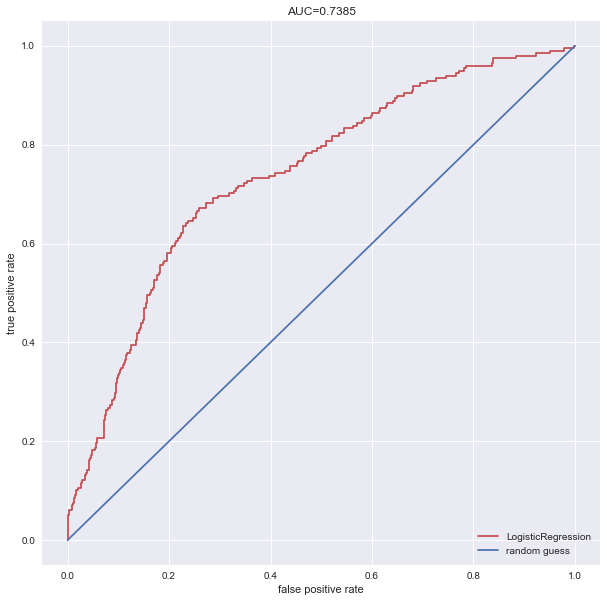

In [26]:
#ROC curve 표현
fpr, tpr, _ = roc_curve(y_test, lr_preds_proba)
#roc_auc_score 함수를 이용하여 곡선의 밑면적과 관련된 정보 사용
auc = roc_auc_score(y_test, lr_preds_proba)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, "r-", label="LogisticRegression")
plt.plot([0, 1], [0, 1], "b-", label="random guess")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("AUC={0:.4f}".format(auc))
plt.legend(loc="lower right");

## 불균형 데이터 해결
### - Undersampling: 데이터 분포가 높은 값을 낮은 값으로 맞춰줌
#### 장점: 유의미한 데이터만 남길 수 있음
#### 단점: 데이터 손실
#### 종류:
#### · Random Under Sampling (무작위 샘플링)
#### · Tomek link (분포가 작은 클래스의 데이터에서 가장 가까운 분포가 높은 데이터의 위치를 찾는 것)
#### · Condensed Nearest Neighbour (최근접인 클래스 분포 데이터를 삭제하면서 샘플링하는 방법)
#### · Edited Nearest Neighbours (소수 클래스 주변의 다중 클래스 값을 제거하는 방법)
#### · Neighbourhood Cleansing Rule (CNN과 ENN을 섞은 방법)
### - Oversampling: 데이터 분포가 낮은 값을 높은 값으로 맞춰줌
#### 장점: 데이터 손실 없음
#### 단점: 오버피팅 가능성
#### 종류:
#### · Random Under Sampling (무작위 샘플링)
#### · Adaptive Synthetic Sampling (분포가 작은 클래스 데이터와 그 데이터와 가장 가까운 무작위의 K개의 데이터 사이에 가상의 직선을 그려서 직선상에 존재하는 가상의 분포가 작은 클래스 데이터를 생성하는 것)
#### · SMOTE (ADASYN과 같은 방법론으로 데이터를 생성하지만 생성된 데이터가 분포가 적은 클래스에 포함되는 것이 아니라 분류 모형에 따라서 다르게 분류)

### SMOTE Oversampling 적용

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (2966, 13) (2966,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5040, 13) (5040,)
SMOTE 적용 후 레이블 값 분포: 
 0    2520
1    2520
Name: TenYearCHD, dtype: int64


In [28]:
lr_smote = LogisticRegression()
lr_smote.fit(x_train_over, y_train_over)
pred_smote = lr_smote.predict(x_test)

#정확도, 정밀도, 재현율, f1_score, roc_auc 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#정확도: 실측값, 예측값 순으로 작성
print('accuracy:{:0.4f}'.format(accuracy_score(y_test, pred_smote)))
print('precision:{:0.4f}'.format(precision_score(y_test, pred_smote)))
print('recall:{:0.4f}'.format(recall_score(y_test, pred_smote)))
print('f1:{:0.4f}'.format(f1_score(y_test, pred_smote)))
print('roc_auc:{:0.4f}'.format(roc_auc_score(y_test, pred_smote)))

accuracy:0.5928
precision:0.2163
recall:0.6162
f1:0.3202
roc_auc:0.6023


#### GridSearCV로 구했던 최적 파라미터 값 대입

In [29]:
lr_smote = LogisticRegression(penalty='l2', C=5, max_iter=550)
lr_smote.fit(x_train_over, y_train_over)
pred_smote = lr_smote.predict(x_test)

#정확도, 정밀도, 재현율, f1_score, roc_auc 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#정확도: 실측값, 예측값 순으로 작성
print('accuracy:{:0.4f}'.format(accuracy_score(y_test, pred_smote)))
print('precision:{:0.4f}'.format(precision_score(y_test, pred_smote)))
print('recall:{:0.4f}'.format(recall_score(y_test, pred_smote)))
print('f1:{:0.4f}'.format(f1_score(y_test, pred_smote)))
print('roc_auc:{:0.4f}'.format(roc_auc_score(y_test, pred_smote)))

accuracy:0.6533
precision:0.2535
recall:0.6313
f1:0.3618
roc_auc:0.6443


### - LightGBM 모델 적용

In [30]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
lgbm.fit(x_train, y_train)
pred_lgbm = lgbm.predict(x_test)

#정확도, 정밀도, 재현율, f1_score, roc_auc 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#정확도: 실측값, 예측값 순으로 작성
print('accuracy:{:0.4f}'.format(accuracy_score(y_test, pred_lgbm)))
print('precision:{:0.4f}'.format(precision_score(y_test, pred_lgbm)))
print('recall:{:0.4f}'.format(recall_score(y_test, pred_lgbm)))
print('f1:{:0.4f}'.format(f1_score(y_test, pred_lgbm)))
print('roc_auc:{:0.4f}'.format(roc_auc_score(y_test, pred_lgbm)))

accuracy:0.8388
precision:0.4426
recall:0.1364
f1:0.2085
roc_auc:0.5524


### - LightGBM + SMOTE 모델 적용

In [31]:
from lightgbm import LGBMClassifier
lgbm_smote = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
lgbm_smote.fit(x_train_over, y_train_over)
pred_lgbmsm = lgbm_smote.predict(x_test)

#정확도, 정밀도, 재현율, f1_score, roc_auc 측정
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#정확도: 실측값, 예측값 순으로 작성
print('accuracy:{:0.4f}'.format(accuracy_score(y_test, pred_lgbmsm)))
print('precision:{:0.4f}'.format(precision_score(y_test, pred_lgbmsm)))
print('recall:{:0.4f}'.format(recall_score(y_test, pred_lgbmsm)))
print('f1:{:0.4f}'.format(f1_score(y_test, pred_lgbmsm)))
print('roc_auc:{:0.4f}'.format(roc_auc_score(y_test, pred_lgbmsm)))

accuracy:0.8239
precision:0.3700
recall:0.1869
f1:0.2483
roc_auc:0.5641


### 한계: LightGBM은 작은 데이터에 대해 과적합하기 쉬움

### 오즈비는 1을 기준으로 떨어져있는 정도를 통해 종속변수에 미치는 영향의 방향을 파악 가능
### - 최대가능도추정법: 주어진 표본에 대하여 가능도를 최대로 갖는 모수 𝜽 를 찾는 방법
#### 가능도: 나타난 결과에 따라 여러 가능한 가설들을 평가할 수 있는 측도
#### 최대가능도: 나타난 결과에 해당하는 가설마다 계산된 가능도 값 중 가장 큰 값
### 파라미터 𝜽에 대하여 파라미터 𝜽에 대하여 편미분하고, 그 값이 0이 되도록 하는 𝜽를 찾는 과정